In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, coherent_unitary_error

from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeBrooklynV2

# from qiskit.quantum_info import Kraus, SuperOp

# Import from Qiskit Aer noise module
# import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle

from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import GetGHZCircuitsForModel
from circuits.pqc_circuits import qiskit_PQC_RZRX_unique, qiskit_PQC_RXRZ_unique
from circuits.modify_circuits import append_pqc_to_quantum_circuit

from models.noise_models import BitPhaseFlipNoise
from models.qiskit_models import SimpleQiskitQuantumModel

from simulator.simulate import get_ideal_data, get_ideal_data_superpos

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 10

ideal_sim = AerSimulator(device=aer_device)

pqc_arch = qiskit_PQC_RXRZ_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = SimpleQiskitQuantumModel(
    num_params=NUM_QUBITS*2, simulator=ideal_sim, num_shots=NUM_SHOTS, pqc_arch_func=pqc_arch
)

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
)



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=int(10000), device=aer_device)
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:15<00:00, 646.72it/s]

32


In [9]:
param_list = []
loss_list_epoch = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    loss_list = [0]
    shuffle(ideal_data)
    data_iterator_tqdm = tqdm(ideal_data)
    for params, ideal in data_iterator_tqdm:
        ctr += 1
        optimizer.zero_grad()

        measured = pqc_model(circuit=ghz_circuit_gen.get_noisy_model_circuit_params(params))
        # print(ideal)
        ideal = ideal.float().to(torch_device)
        measured = measured.float().to(torch_device)
        
        loss = loss_fn(ideal, measured)

        loss.backward()
        optimizer.step()

        param_values = pqc_model.pqc_params.detach().cpu().numpy().copy()
        param_list.append(param_values)
        loss_list.append(loss.item())
        data_iterator_tqdm.set_postfix_str(f"Loss: {loss}")
        # print(param_list)


        # if (ctr) % (len(ideal_data) // 10) == 0:
            
    print(f'Loss: {np.mean(loss_list):.4f}, Params: {pqc_model.pqc_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')
    param_arr = np.array(param_list).transpose()
    print(param_arr)    
    loss_list_epoch.append(np.mean(loss_list))

    

Starting Epoch 1


100%|██████████| 10000/10000 [01:53<00:00, 88.28it/s, Loss: 1440.125]  


Loss: 7448.2418, Params: Parameter containing:
tensor([5.4525, 5.3441, 5.0714, 5.3942, 5.1420, 5.7277, 5.7130, 4.9802, 5.2579,
        5.4129], requires_grad=True)
[[14.823087  14.821604  14.820122  ...  5.453561   5.4530153  5.45247  ]
 [14.528526  14.527073  14.5256195 ...  5.3452005  5.344666   5.3441315]
 [13.78711   13.785731  13.784352  ...  5.0724235  5.071916   5.0714087]
 ...
 [13.539143  13.537788  13.536434  ...  4.9811916  4.9806933  4.980195 ]
 [14.294157  14.292727  14.291298  ...  5.2589736  5.2584476  5.2579217]
 [14.715458  14.713986  14.712515  ...  5.4139643  5.4134226  5.4128814]]
Starting Epoch 2


100%|██████████| 10000/10000 [01:59<00:00, 83.80it/s, Loss: 20915.875]


Loss: 11588.7486, Params: Parameter containing:
tensor([2.0054, 1.9656, 1.8653, 1.9840, 1.8912, 2.1066, 2.1013, 1.8317, 1.9339,
        1.9909], requires_grad=True)
[[14.823087  14.821604  14.820122  ...  2.0058148  2.0056143  2.0054138]
 [14.528526  14.527073  14.5256195 ...  1.9659653  1.9657687  1.9655721]
 [13.78711   13.785731  13.784352  ...  1.8656387  1.8654522  1.8652656]
 ...
 [13.539143  13.537788  13.536434  ...  1.8320807  1.8318975  1.8317143]
 [14.294157  14.292727  14.291298  ...  1.9342526  1.9340591  1.9338657]
 [14.715458  14.713986  14.712515  ...  1.9912533  1.991054   1.990855 ]]
Starting Epoch 3


100%|██████████| 10000/10000 [01:57<00:00, 84.96it/s, Loss: 12195.0]   


Loss: 9105.6993, Params: Parameter containing:
tensor([0.7376, 0.7229, 0.6860, 0.7297, 0.6956, 0.7748, 0.7728, 0.6737, 0.7113,
        0.7322], requires_grad=True)
[[14.823087   14.821604   14.820122   ...  0.7377392   0.7376654
   0.7375916 ]
 [14.528526   14.527073   14.5256195  ...  0.7230827   0.7230104
   0.7229381 ]
 [13.78711    13.785731   13.784352   ...  0.68618184  0.68611324
   0.68604463]
 ...
 [13.539143   13.537788   13.536434   ...  0.67383885  0.67377144
   0.673704  ]
 [14.294157   14.292727   14.291298   ...  0.71141803  0.71134686
   0.7112757 ]
 [14.715458   14.713986   14.712515   ...  0.7323825   0.7323092
   0.73223597]]
Starting Epoch 4


100%|██████████| 10000/10000 [01:59<00:00, 83.46it/s, Loss: 4998.6875] 


Loss: 4782.0820, Params: Parameter containing:
tensor([0.2713, 0.2659, 0.2523, 0.2684, 0.2558, 0.2850, 0.2843, 0.2478, 0.2616,
        0.2693], requires_grad=True)
[[14.823087   14.821604   14.820122   ...  0.2713406   0.27131346
   0.2712863 ]
 [14.528526   14.527073   14.5256195  ...  0.26595014  0.26592353
   0.26589695]
 [13.78711    13.785731   13.784352   ...  0.25237778  0.25235254
   0.2523273 ]
 ...
 [13.539143   13.537788   13.536434   ...  0.24783754  0.24781276
   0.24778798]
 [14.294157   14.292727   14.291298   ...  0.26165956  0.2616334
   0.26160723]
 [14.715458   14.713986   14.712515   ...  0.26936972  0.26934278
   0.26931584]]
Starting Epoch 5


100%|██████████| 10000/10000 [01:56<00:00, 85.84it/s, Loss: 3247.375]  


Loss: 2888.7084, Params: Parameter containing:
tensor([0.0998, 0.0978, 0.0928, 0.0987, 0.0941, 0.1048, 0.1045, 0.0911, 0.0962,
        0.0991], requires_grad=True)
[[14.823087   14.821604   14.820122   ...  0.09979921  0.09978922
   0.09977924]
 [14.528526   14.527073   14.5256195  ...  0.09781653  0.09780674
   0.09779696]
 [13.78711    13.785731   13.784352   ...  0.09282451  0.09281523
   0.09280594]
 ...
 [13.539143   13.537788   13.536434   ...  0.09115455  0.09114543
   0.09113631]
 [14.294157   14.292727   14.291298   ...  0.09623843  0.09622881
   0.09621918]
 [14.715458   14.713986   14.712515   ...  0.09907409  0.09906418
   0.09905427]]
Starting Epoch 6


100%|██████████| 10000/10000 [02:00<00:00, 83.25it/s, Loss: 937.6875]  


Loss: 2288.2909, Params: Parameter containing:
tensor([0.0367, 0.0360, 0.0341, 0.0363, 0.0346, 0.0386, 0.0385, 0.0335, 0.0354,
        0.0364], requires_grad=True)
[[14.823087   14.821604   14.820122   ...  0.03670619  0.03670252
   0.03669885]
 [14.528526   14.527073   14.5256195  ...  0.03597692  0.03597332
   0.03596972]
 [13.78711    13.785731   13.784352   ...  0.03414086  0.03413744
   0.03413403]
 ...
 [13.539143   13.537788   13.536434   ...  0.03352658  0.03352322
   0.03351987]
 [14.294157   14.292727   14.291298   ...  0.03539653  0.03539299
   0.03538945]
 [14.715458   14.713986   14.712515   ...  0.03643943  0.03643579
   0.03643215]]
Starting Epoch 7


100%|██████████| 10000/10000 [01:43<00:00, 97.08it/s, Loss: 4269.4375] 


Loss: 2094.2502, Params: Parameter containing:
tensor([0.0135, 0.0132, 0.0126, 0.0134, 0.0127, 0.0142, 0.0141, 0.0123, 0.0130,
        0.0134], requires_grad=True)
[[1.48230867e+01 1.48216038e+01 1.48201218e+01 ... 1.35005498e-02
  1.34991994e-02 1.34978490e-02]
 [1.45285263e+01 1.45270729e+01 1.45256195e+01 ... 1.32323066e-02
  1.32309832e-02 1.32296598e-02]
 [1.37871103e+01 1.37857313e+01 1.37843523e+01 ... 1.25570176e-02
  1.25557613e-02 1.25545058e-02]
 ...
 [1.35391426e+01 1.35377884e+01 1.35364342e+01 ... 1.23310722e-02
  1.23298392e-02 1.23286061e-02]
 [1.42941570e+01 1.42927275e+01 1.42912979e+01 ... 1.30188353e-02
  1.30175333e-02 1.30162314e-02]
 [1.47154579e+01 1.47139864e+01 1.47125149e+01 ... 1.34024443e-02
  1.34011041e-02 1.33997640e-02]]
Starting Epoch 8


100%|██████████| 10000/10000 [02:25<00:00, 68.77it/s, Loss: 726.0625]  


Loss: 2022.9017, Params: Parameter containing:
tensor([0.0050, 0.0049, 0.0046, 0.0049, 0.0047, 0.0052, 0.0052, 0.0045, 0.0048,
        0.0049], requires_grad=True)
[[1.48230867e+01 1.48216038e+01 1.48201218e+01 ... 4.96550556e-03
  4.96500870e-03 4.96451231e-03]
 [1.45285263e+01 1.45270729e+01 1.45256195e+01 ... 4.86683613e-03
  4.86634951e-03 4.86586289e-03]
 [1.37871103e+01 1.37857313e+01 1.37843523e+01 ... 4.61847568e-03
  4.61801374e-03 4.61755181e-03]
 ...
 [1.35391426e+01 1.35377884e+01 1.35364342e+01 ... 4.53537097e-03
  4.53491742e-03 4.53446386e-03]
 [1.42941570e+01 1.42927275e+01 1.42912979e+01 ... 4.78832843e-03
  4.78784973e-03 4.78737103e-03]
 [1.47154579e+01 1.47139864e+01 1.47125149e+01 ... 4.92942147e-03
  4.92892833e-03 4.92843520e-03]]
Starting Epoch 9


100%|██████████| 10000/10000 [02:17<00:00, 72.66it/s, Loss: 1262.0]    


Loss: 1995.7563, Params: Parameter containing:
tensor([0.0018, 0.0018, 0.0017, 0.0018, 0.0017, 0.0019, 0.0019, 0.0017, 0.0018,
        0.0018], requires_grad=True)
[[1.48230867e+01 1.48216038e+01 1.48201218e+01 ... 1.82631484e-03
  1.82613218e-03 1.82594953e-03]
 [1.45285263e+01 1.45270729e+01 1.45256195e+01 ... 1.79002085e-03
  1.78984180e-03 1.78966275e-03]
 [1.37871103e+01 1.37857313e+01 1.37843523e+01 ... 1.69867638e-03
  1.69850653e-03 1.69833668e-03]
 ...
 [1.35391426e+01 1.35377884e+01 1.35364342e+01 ... 1.66811212e-03
  1.66794530e-03 1.66777847e-03]
 [1.42941570e+01 1.42927275e+01 1.42912979e+01 ... 1.76114729e-03
  1.76097115e-03 1.76079501e-03]
 [1.47154579e+01 1.47139864e+01 1.47125149e+01 ... 1.81304407e-03
  1.81286270e-03 1.81268144e-03]]
Starting Epoch 10


100%|██████████| 10000/10000 [01:46<00:00, 94.16it/s, Loss: 454.875]   


Loss: 1984.8463, Params: Parameter containing:
tensor([0.0007, 0.0007, 0.0006, 0.0007, 0.0006, 0.0007, 0.0007, 0.0006, 0.0006,
        0.0007], requires_grad=True)
[[1.48230867e+01 1.48216038e+01 1.48201218e+01 ... 6.71719084e-04
  6.71651913e-04 6.71584741e-04]
 [1.45285263e+01 1.45270729e+01 1.45256195e+01 ... 6.58368983e-04
  6.58303150e-04 6.58237317e-04]
 [1.37871103e+01 1.37857313e+01 1.37843523e+01 ... 6.24774140e-04
  6.24711625e-04 6.24649168e-04]
 ...
 [1.35391426e+01 1.35377884e+01 1.35364342e+01 ... 6.13532204e-04
  6.13470853e-04 6.13409502e-04]
 [1.42941570e+01 1.42927275e+01 1.42912979e+01 ... 6.47750334e-04
  6.47685549e-04 6.47620764e-04]
 [1.47154579e+01 1.47139864e+01 1.47125149e+01 ... 6.66838081e-04
  6.66771375e-04 6.66704669e-04]]


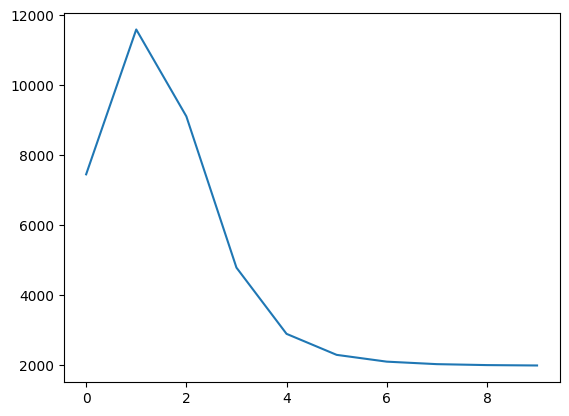

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
param_arr = np.array(param_list).transpose()
print(param_arr)

[[1.48230867e+01 1.48216038e+01 1.48201218e+01 ... 6.71719084e-04
  6.71651913e-04 6.71584741e-04]
 [1.45285263e+01 1.45270729e+01 1.45256195e+01 ... 6.58368983e-04
  6.58303150e-04 6.58237317e-04]
 [1.37871103e+01 1.37857313e+01 1.37843523e+01 ... 6.24774140e-04
  6.24711625e-04 6.24649168e-04]
 ...
 [1.35391426e+01 1.35377884e+01 1.35364342e+01 ... 6.13532204e-04
  6.13470853e-04 6.13409502e-04]
 [1.42941570e+01 1.42927275e+01 1.42912979e+01 ... 6.47750334e-04
  6.47685549e-04 6.47620764e-04]
 [1.47154579e+01 1.47139864e+01 1.47125149e+01 ... 6.66838081e-04
  6.66771375e-04 6.66704669e-04]]


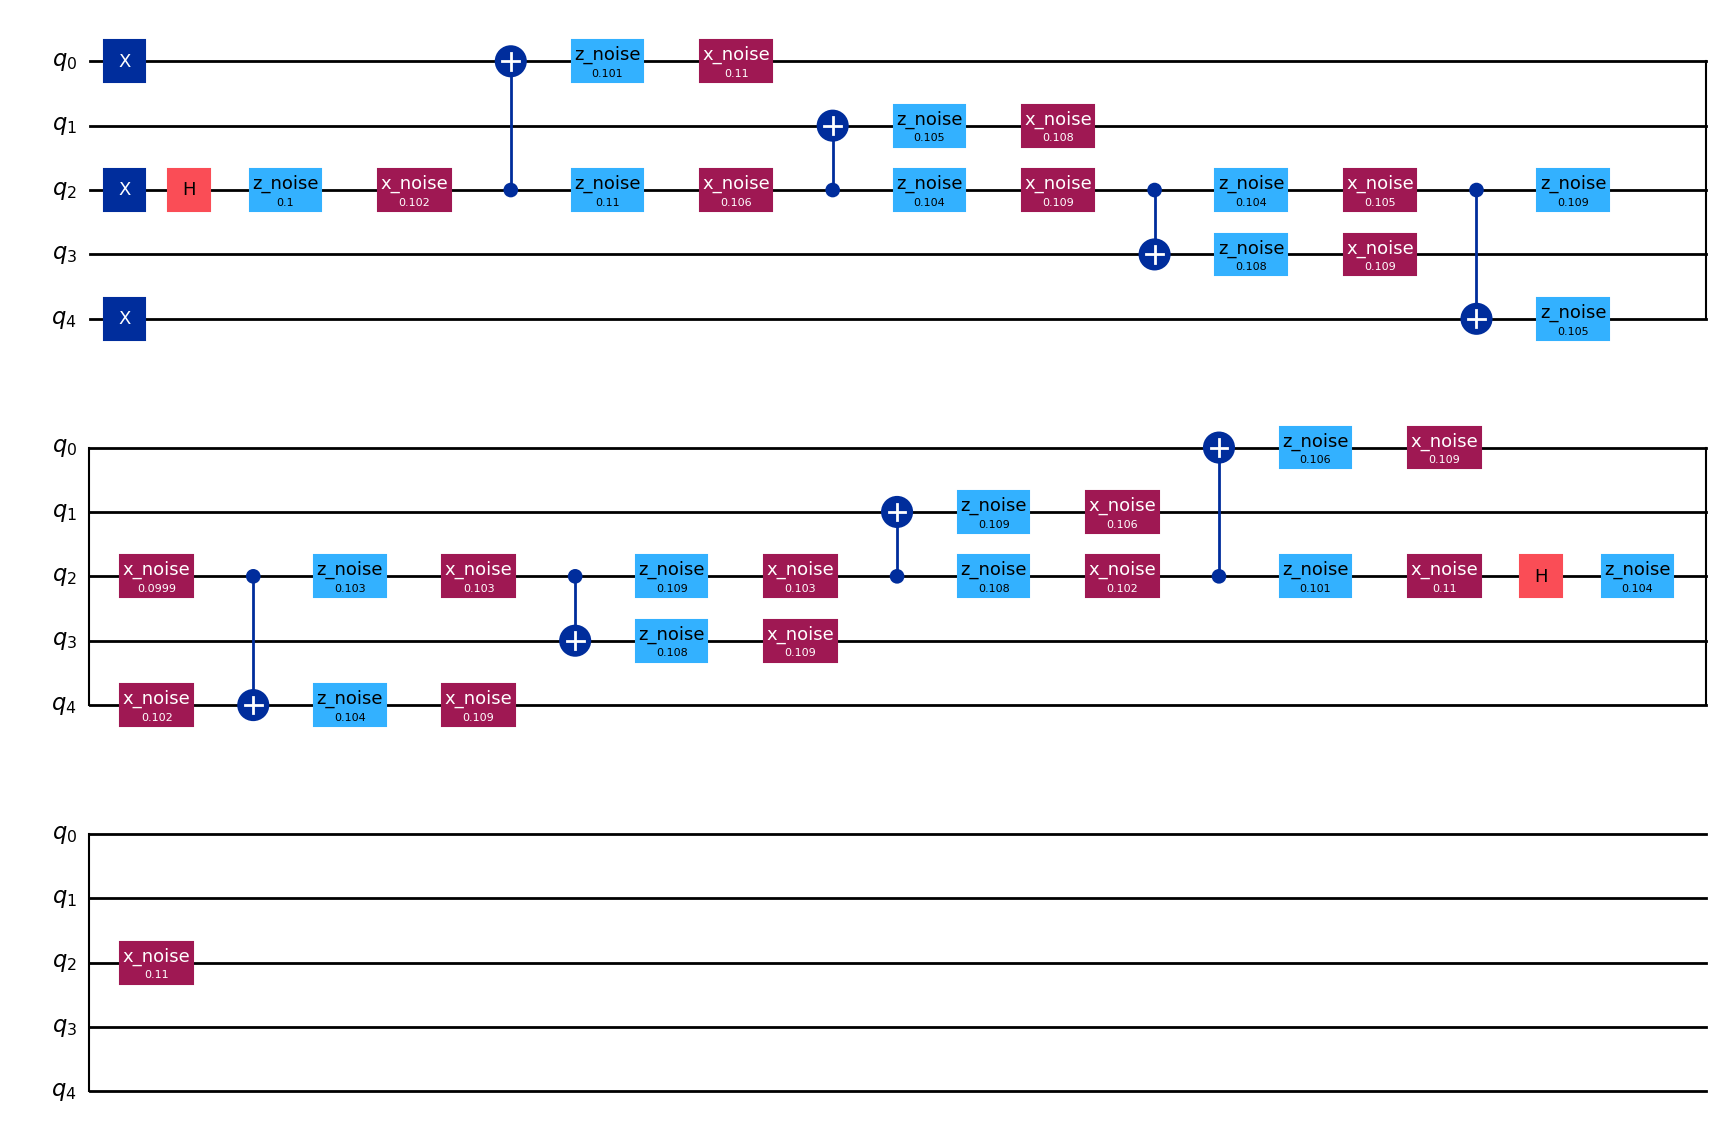

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

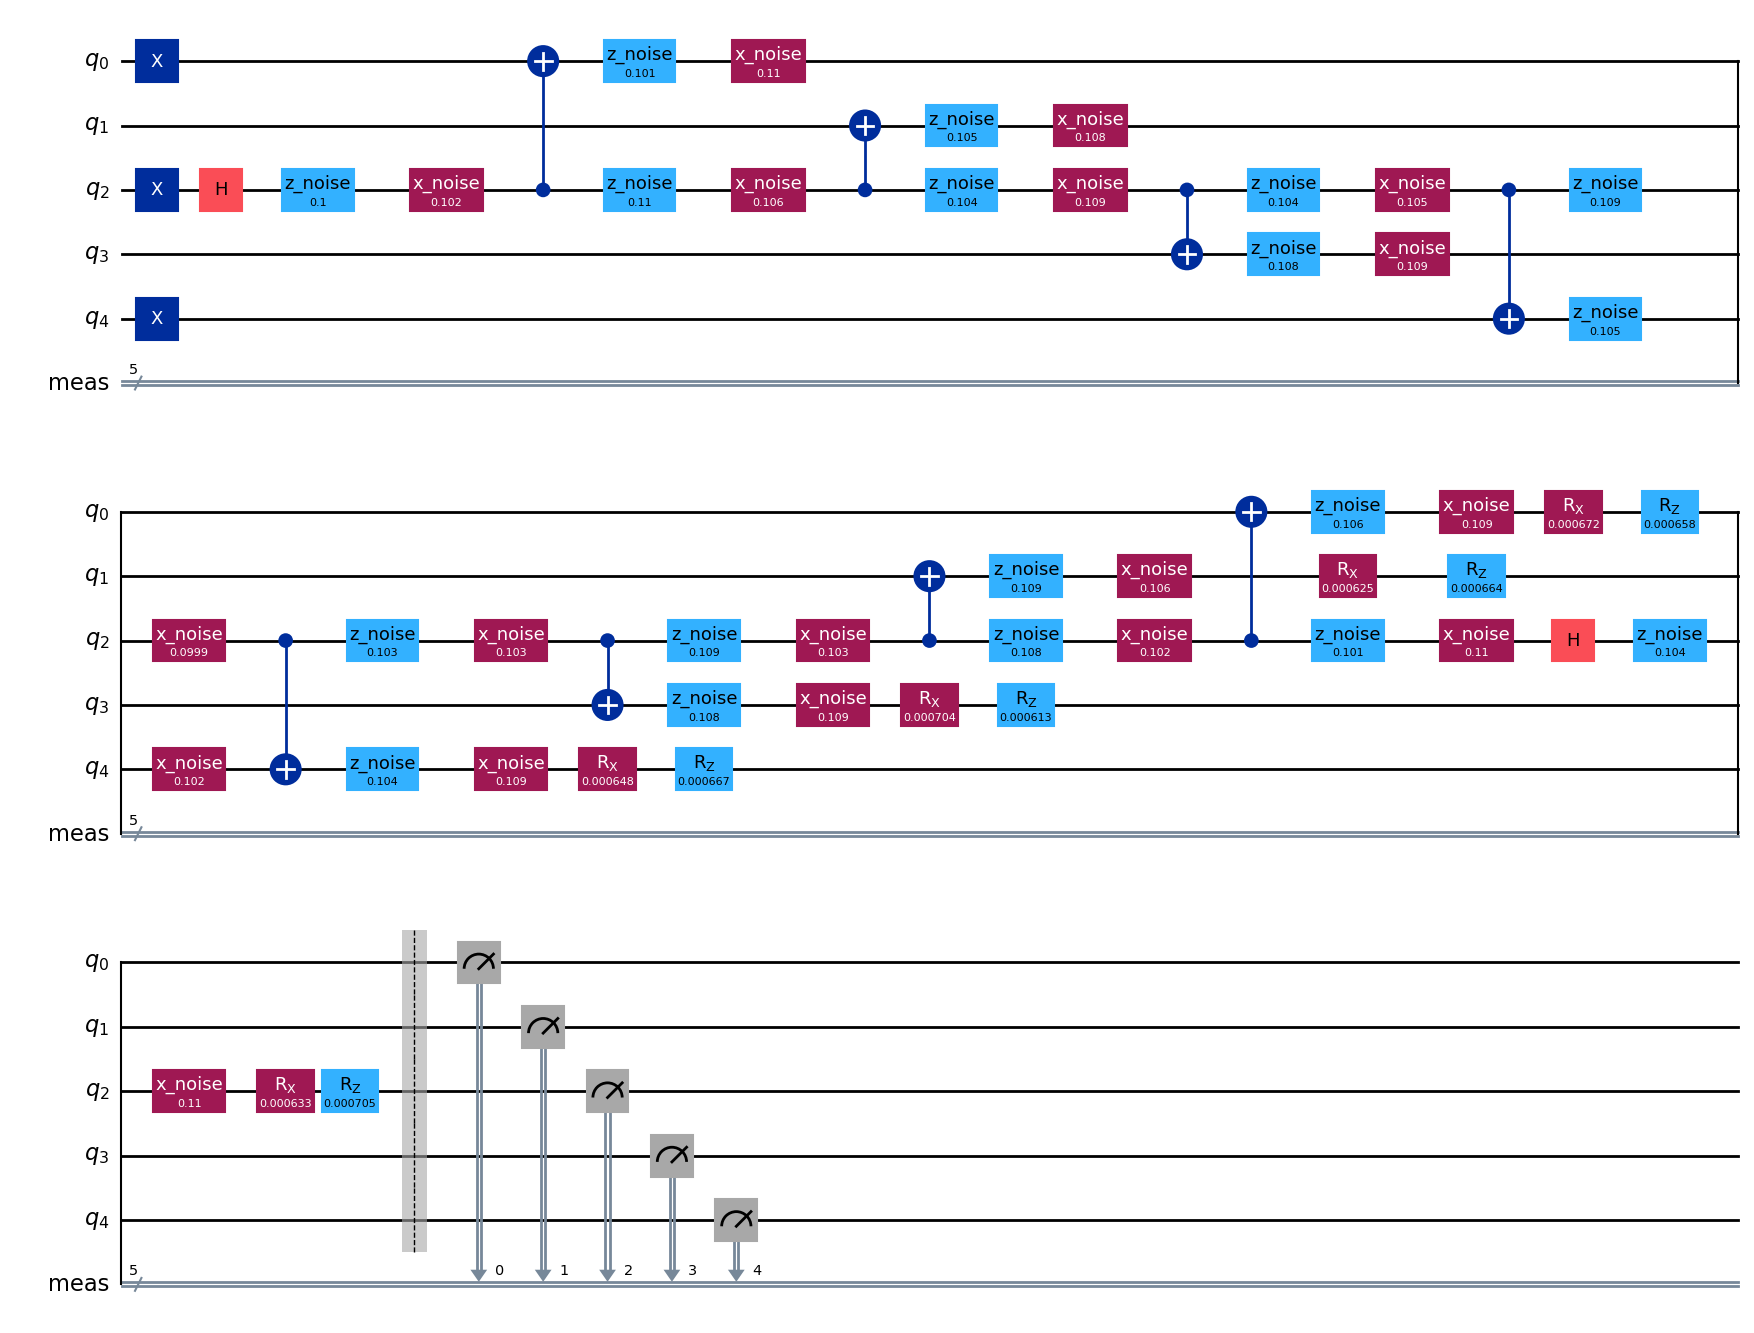

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.pqc_params, pqc_arch)
noisy_model_circ_pqc.draw('mpl')

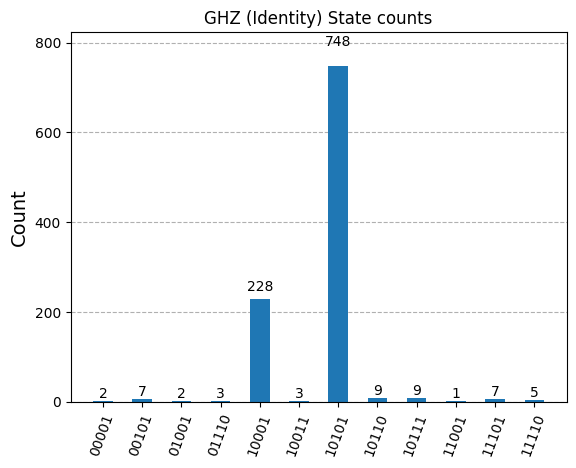

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

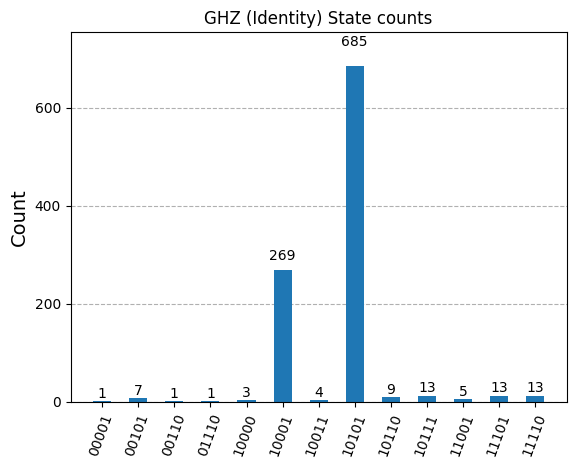

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

In [17]:
from simulator.simulate import run_circuit_sampler

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def fidelity(p, q):
    return torch.square(torch.sqrt(p * q).sum())

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.pqc_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=20)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, pqc_arch)

    counts_noisy = run_circuit_sampler(noisy_circ.measure_all(inplace=False))
    counts_noisy_pqc = run_circuit_sampler(noisy_circ_pqc)

    prob_i = counts_to_probs(ideal)
    prob_n = counts_to_probs(counts_noisy)
    prob_ne = counts_to_probs(counts_noisy_pqc)

    fid_i_n = fidelity(prob_i, prob_n)
    fid_i_ne = fidelity(prob_i, prob_ne)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 628.06it/s]


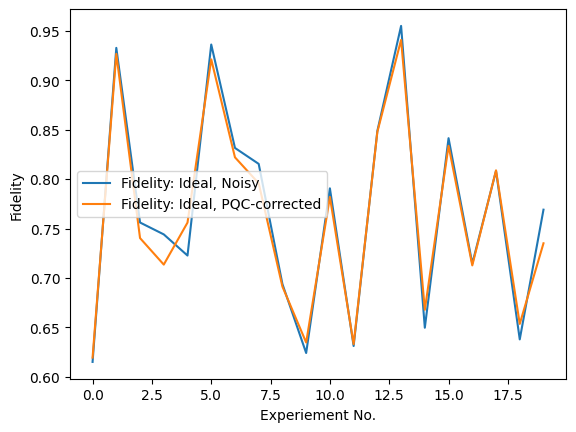

In [18]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [ ]:
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()